In [ ]:
# Will be three modeling steps:
# Model inputs: State budget, max travel distance
# 1. Demand maximation (s/t cost, distance), gives # people we can route to a hub
# 2. Aggregate distance minimization
# 3. Use (x) * # people, (y) * distance for cost minimization

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyomo.environ import *
import pyomo.opt as pyopt

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean

import itertools

import matplotlib.pyplot as plt
import plotly.express as px
import shapely
import folium
import plotly.graph_objects as go # or plotly.express as px

from data_cleaning_cmm import (blockgroup_pop_dict, bg_ces_dict,
                               dist_to_site_contra_costa_df, dist_to_site_contra_costa_dict,
                               dist_to_site_contra_costa_walk_df, dist_to_site_contra_costa_walk_dict,
                               dist_to_site_wilmington_df, dist_to_site_wilmington_dict,
                               dist_to_site_wilmington_walk_df, dist_to_site_wilmington_walk_dict,
                           county_prop_ealp_dict, site_kw_occ_dict,
                           site_sqft_dict, site_cost_dict)

In [2]:
# Base model
import deployment_models
import importlib
importlib.reload(deployment_models)

model_base, bg_with_no_hub = deployment_models.build_base_model(site_cost_dict, site_kw_occ_dict, blockgroup_pop_dict, bg_ces_dict, dist_to_site_contra_costa_df)

In [3]:
# Demand maximization s/t budget

max_cost = 20000000 # $ that we can spend on hubs
prop_served_scale_factor = .5
agg_dist_scale_factor = 1.5

model_dict = dict()

######### Basic demand maximization #############
# Demand maximization objective and constraint for total cost and to meet defined proportion of total population
model_key = "demand_max"
model_dict[model_key] = model_base.clone()
model_dict[model_key] = deployment_models.constrain_total_cost(model_dict[model_key],max_cost)
model_dict[model_key] = deployment_models.add_demand_maximization_objective(model_dict[model_key])
results = SolverFactory('gurobi').solve(model_dict[model_key])
#print(results)
var_hub_yn, var_bg_pop, var_prop_served, var_distance_matrix = deployment_models.get_variables_from_model(model_dict[model_key])

# Calculate number of people served
num_served_bg = var_prop_served.sum(axis = 1)*var_bg_pop['POPULATION']
prop_served = sum(num_served_bg.loc[num_served_bg != 0])/sum(var_bg_pop['POPULATION'])
scaled_prop_served = prop_served * prop_served_scale_factor


In [4]:
######### Basic p median #############
# p median objective and constraint for total cost and to meet defined proportion of total population
model_key = "p_median"
model_dict[model_key] = model_base.clone()
model_dict[model_key] = deployment_models.constrain_total_cost(model_dict[model_key],max_cost)
model_dict[model_key] = deployment_models.constrain_min_total_pop(model_dict[model_key],scaled_prop_served)
model_dict[model_key] = deployment_models.add_p_median_objective(model_dict[model_key])
results = SolverFactory('gurobi').solve(model_dict[model_key])
#print(results)
var_hub_yn, var_bg_pop, var_prop_served, var_distance_matrix = deployment_models.get_variables_from_model(model_dict[model_key])

# Create set of blockgroup, site pairs within five miles of each other
def filter_to_nearby_sites(bg, site):
    return not np.isnan(var_distance_matrix.loc[bg, site])

bg_site_pairs = list(itertools.product(var_distance_matrix.columns,var_distance_matrix.index))
bg_site_pairs = [x for x in bg_site_pairs if filter_to_nearby_sites(x[1], x[0])]

# Calculate aggregate distance and scaled aggregated distance
agg_dist = sum([var_bg_pop.loc[bg, 'POPULATION'] * var_distance_matrix.loc[bg, site] * var_prop_served.loc[bg, site] for site, bg in bg_site_pairs])
scaled_agg_dist = agg_dist * agg_dist_scale_factor


In [5]:
######### Cost Minimization #############
# cost minimization objective and constraints for aggregate distance and proportion of the population served
# takes amount we can spend on hubs, miles we can go to a hub, scale factors, 
model_key = "cost"
model_dict[model_key] = model_base.clone()
model_dict[model_key] = deployment_models.constrain_maximum_agg_distance(model_dict[model_key],scaled_agg_dist)
model_dict[model_key] = deployment_models.constrain_min_total_pop(model_dict[model_key],scaled_prop_served)
model_dict[model_key] = deployment_models.add_cost_minimzation_objective(model_dict[model_key])
results = SolverFactory('gurobi').solve(model_dict[model_key])
#print(results)
var_hub_yn, var_bg_pop, var_prop_served, var_distance_matrix = deployment_models.get_variables_from_model(model_dict[model_key])


In [174]:
scaled_prop_served

0.05945618093079222

In [177]:
######### Cost Minimization with CES #############
# cost minimization objective and constraints for aggregate distance and proportion of the population served
# takes amount we can spend on hubs, scaled aggregate distance and proportion served, and CES constraint
min_prop_ej = scaled_prop_served
ej_cutoff = 0.75 # for bg with greater than this percentile, must serve at least min_prop_ej

model_key = "cost"
model_dict[model_key] = model_base.clone()
model_dict[model_key] = deployment_models.constrain_maximum_agg_distance(model_dict[model_key],scaled_agg_dist)
model_dict[model_key] = deployment_models.constrain_min_total_pop(model_dict[model_key],scaled_prop_served)
model = deployment_models.prioritize_CES(model_dict[model_key],min_prop_ej,ej_cutoff)
model_dict[model_key] = deployment_models.add_cost_minimzation_objective(model_dict[model_key])
results = SolverFactory('gurobi').solve(model_dict[model_key])
#print(results)
var_hub_yn_ces, var_bg_pop_ces, var_prop_served_ces, var_distance_matrix_ces = deployment_models.get_variables_from_model(model_dict[model_key])


In [178]:
# function that takes resilience hub or block group data and id,
# and returns coordinates of hub or block group corresponding to id
def locate(data, id, col):
    row = data.loc[data[col] == id]
    return [row['LAT'].iloc[0], row['LON'].iloc[0]]

# Map hub locations based on built_yn
def map_hubs(built_yn, site_data):
    sites = pd.DataFrame(columns = ['LAT', 'LON'])
    hubs = var_hub_yn.loc[var_hub_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(site_data, site, 'id_site')
        sites.loc[len(sites.index)] = site_pt
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], mapbox_style="open-street-map", zoom=10)
    fig.show()

In [182]:
# Load sites data
ca_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4629'
wgs84 = 'EPSG:4326'

# Building candidate sites GeoDataFrame
sites_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_sites_campuses.csv')
sites_df_raw = pd.read_csv(sites_path)
sites_df_raw = sites_df_raw.loc[sites_df_raw['cat_site'] != 'X', ['id_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom = gpd.points_from_xy(sites_df_raw.LON, sites_df_raw.LAT, crs = nad83)
sites_gdf = gpd.GeoDataFrame(sites_df_raw, geometry = sites_geom, crs = nad83)

hubs = var_hub_yn.loc[var_hub_yn['BUILT'] == 1].index
hubs_ces = var_hub_yn_ces.loc[var_hub_yn_ces['BUILT'] == 1].index

In [183]:
map_hubs(var_hub_yn_ces, sites_gdf)

In [185]:
# Use model output as input to a distance matrix-making script, 
# creating a distance matrix from all block groups to all hubs
hubs = var_hub_yn.loc[var_hub_yn['BUILT'] == 1].index

# create hubs gdf with built hubs only
hubs_gdf = sites_gdf.loc[sites_gdf['id_site'].isin(list(hubs))]

In [163]:
# function that takes distance matrix and hub ids, and outputs list of block
# groups that don't have a distance less than max_distance to one of the built hubs
def no_distance(hub_ids, distances, max_distance):
    filtered = distances[hub_ids]
    filtered.where(filtered < max_distance, None, inplace=True)
    #print(list(filtered[~filtered.isnull().all(axis=1)].max(axis = 1)))
    return filtered[filtered.isnull().all(axis=1)].index

# function that takes distance matrix and hub ids, and outputs list of block
# groups that do have a distance less than max_distance to one of the built hubs
def yes_distance(hub_ids, distances, max_distance):
    filtered = distances[hub_ids]
    filtered.where(filtered < max_distance, None, inplace=True)
    #print(list(filtered[~filtered.isnull().all(axis=1)].max(axis = 1)))
    return filtered[~filtered.isnull().all(axis=1)].index

# function that takes distance matrix and hub ids, and outputs dataframe of bg id and 
# closest hub id under max_distance away, with bgs without a hub under max_distance away
# not included
def get_closest_hubs(hub_ids, distances, max_distance):
    filtered = distances[hub_ids]
    filtered.where(filtered < max_distance, None, inplace=True)
    distances = filtered[~filtered.isnull().all(axis=1)].idxmin(axis = 1)
    return pd.DataFrame(data = distances, columns = ['site_id'])

# function that returns list of passed characteristic in passed data frame
# for passed list of block group ids
def retrieve_characteristics(hub_ids, data, characteristic):
    return data.loc[data['GISJOIN'].isin(list(hub_ids))][characteristic]

# function that takes an array of arrays of block group ids, data (from CES), group names, 
# and a desired characteristic and creates a boxplot
def boxplot_characteristics(list_bg_ids, data, group_names, characteristic):
    list_x = [[]]*len(list_bg_ids)
    # create x values for plot
    for i in np.arange(len(list_bg_ids)):
        list_x[i] = (retrieve_characteristics(list_bg_ids[i], data, characteristic))
    
    plt.boxplot(list_x, labels = group_names);
    plt.ylabel(characteristic)
    return(plt)
    

In [167]:
# Compare characteristics of people in block groups that matched to a hub
# vs. people in block groups that did not
bg_ces_df = pd.read_csv('data/bg_ca_19/bg19_ces_indicators.csv')
# Potential variables: ['PCT_LESSHS', 'PCT_UNEMP', 'PCT_RENT', 
# 'PCT_LINGISO', 'PCT_POV', 'RATE_ASTH', 'RATE_LBW', 'RATE_CVD']

max_distance = 1.5
hubs = var_hub_yn.loc[var_hub_yn['BUILT'] == 1].index

no = no_distance(hubs, dist_to_site_contra_costa_walk_df, max_distance)
yes = yes_distance(hubs, dist_to_site_contra_costa_walk_df, max_distance)


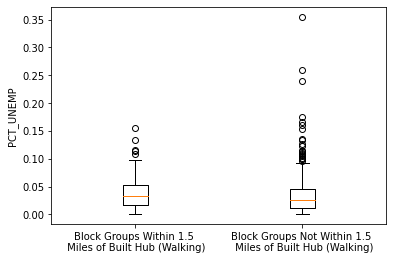

In [188]:
# Proportion of unemployed people
boxplot_characteristics([list(yes), list(no)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_UNEMP');

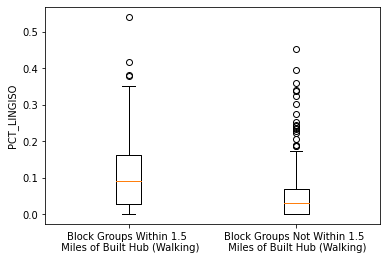

In [170]:
# Proportion of linguistically isolated people
boxplot_characteristics([list(yes), list(no)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_LINGISO');

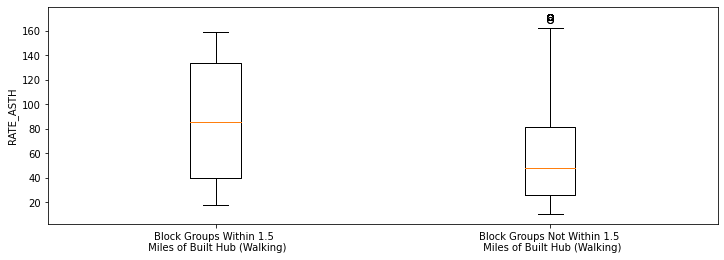

In [191]:
# Asthma Rate
boxplot_characteristics([list(yes), list(no)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'RATE_ASTH');


In [ ]:
# Function for taking county name and hub ids that are built, and returning distance 
# matrix from each block group centroid in county to built hubs
from distance_matrix_functions_cmm import *

k_neighbors = 10 # Find this many nearest neighbors
max_distance = 4 # Find all neighbors within this number of miles

# Building block group GeoDataFrame
bgs_path = os.path.join(os.getcwd(), 'data', 'bg_ca_19', 'shp', 'blockgroup_CA_19.shp')
bgs_gdf = gpd.read_file(bgs_path)
bgs_gdf = bgs_gdf.to_crs(sites_gdf.crs)
bgs_lons = [float(intpt) for intpt in bgs_gdf['INTPTLON']]
bgs_lats = [float(intpt) for intpt in bgs_gdf['INTPTLAT']]
bgs = pd.DataFrame(bgs_gdf[['GISJOIN', 'COUNTYFP']])
bgs['LON'] = bgs_lons
bgs['LAT'] = bgs_lats
bgs_pt_geom = gpd.points_from_xy(x = bgs.LON,y = bgs.LAT, crs = nad83)
bgs_pt_gdf = gpd.GeoDataFrame(bgs, geometry = bgs_pt_geom, crs = nad83)

# Read in county boundaries
county_gdf = gpd.read_file(os.path.join("data","cb_2018_us_county_500k.zip"))
county_gdf = county_gdf[county_gdf["STATEFP"]=='06'] #Just california

# Getting county FIPS codes
ca_county_names = [ \
                    'Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
                   'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo',
                   'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa',
                   'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
                   'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
                   'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
                   'Santa Barbara', 'Santa Clara','Santa Cruz','Shasta', 'Sierra', 'Siskiyou',
                   'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare',
                   'Tuolumne','Ventura', 'Yolo', 'Yuba'
                   ]
ca_county_fips = ['00' + str(int(num)) for num in np.linspace(1, 115, 58)]
ca_county_fips = [num[-3:] for num in ca_county_fips]
ca_counties = {ca_county_names[i]:ca_county_fips[i] for i in range(len(ca_county_names))}
# Subset of counties to limit the analysis to just these counties.
ca_counties_subset = [ \
                        # 'Alameda', 'Alpine', 'Amador', 'Butte',
                        # 'Calaveras', 'Colusa',
                         'Contra Costa',
                        # 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
                        # 'Humboldt', 'Imperial', 'Inyo',
                        # 'Kern', 'Kings', 'Lake', 'Lassen',
                        # 'Los Angeles',
                        # 'Madera', 'Marin', 'Mariposa',
                        # 'Mendocino', 'Merced', 'Modoc', 'Mono',
                        # 'Monterey', 'Napa', 'Nevada', 'Orange',
                        # 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
                        # 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
                        # 'Santa Barbara', 'Santa Clara','Santa Cruz','Shasta', 'Sierra', 'Siskiyou',
                        # 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare',
                        # 'Tuolumne','Ventura', 'Yolo', 'Yuba'
                        ]
ca_counties = {county: ca_counties[county] for county in ca_counties_subset}

county_graph_buffer = 0.1 # Add on this distance to get street nodes/edges from neighboring counties too.
# county = 'Contra Costa';county_fips = '013'

# RUNS VERY SLOWLY -- HAVEN'T SUCCESSFULLY RUN
for county, county_fips in ca_counties.items():
    output_county = county.lower().replace(' ', '')
    output_file_name = os.path.join(os.getcwd(), 'data', 'built_hub_distance_matrices', 'built_hub_distmatrix_walk_' + output_county + '.csv')
    if not(os.path.exists(output_file_name)): # If distance matrix has not been calculated yet
        # Get graph for county
        print("Getting graph for " + county)
        county_bbox = county_gdf.loc[county_gdf["COUNTYFP"]==county_fips,'geometry'].unary_union
        if not(os.path.exists(os.path.join(os.getcwd(), 'data', 'graphs', 'graph_walk_' + output_county + '.graphml'))): # If graph has not been downloaded yet
            county_bbox_buffered = county_bbox.buffer(county_graph_buffer)
            county_graph = get_county_walk_graph_from_polygon(county_bbox_buffered, nad83)
            ox.save_graphml(county_graph, os.path.join(os.getcwd(), 'data', 'graphs', 'graph_walk_' + output_county + '.graphml'))
        else: #Load graph from disk
            county_graph = ox.load_graphml(os.path.join(os.getcwd(), 'data', 'graphs', 'graph_walk_' + output_county + '.graphml'))
        # Get the sites and block groups for just this county
        hubs_county_gdf = hubs_gdf.loc[hubs_gdf.within(county_bbox)]
        bgs_county_gdf = bgs_pt_gdf[bgs_pt_gdf["COUNTYFP"]==county_fips]

        # Get the "names" of the sites and block groups.
        name_index = {i:bgs_county_gdf.iloc[i]['GISJOIN'] for i in range(0, len(bgs_county_gdf))}
        name_columns = {i:hubs_county_gdf.iloc[i]['id_site'] for i in range(0, len(hubs_county_gdf))}

        # Initialize blank matrix
        dist_to_site_matrix = np.NaN*np.zeros((len(bgs_county_gdf), len(hubs_county_gdf)))
        dist_to_site_df = pd.DataFrame(dist_to_site_matrix)
        dist_to_site_df.rename(index = name_index, columns = name_columns, inplace = True)

        # Calculate distance matrix loop
        print("Measuring distances for " + county)
        num_bgs = 0

        for _,bg_row in bgs_county_gdf.iterrows():
            # For timing purposes, see progress
            num_bgs += 1
            if num_bgs%10 == 0:
                print(num_bgs)
            # Get nearest node to blockgroup lat/long
            node_origin = get_coords_and_nearest_node(bg_row['GISJOIN'], 'GISJOIN', bgs_county_gdf, county_graph)

            # Find the nearest built sites
            hubs_nearby = get_nearby_sites_lat_long(bg_row, hubs_county_gdf, k_neighbors, max_distance)
            for site in hubs_nearby: # For each site
                # Find the nearest node on the graph
                node_target = get_coords_and_nearest_node(site, 'id_site', hubs_county_gdf, county_graph)
                try:
                    # Calculate travel distance
                    travel_dist_m = nx.shortest_path_length(county_graph, node_origin, node_target, weight = 'length')
                    # Set travel distance in distance matrix in miles
                    dist_to_site_df.loc[bg_row['GISJOIN'], site] = round(travel_dist_m/1609.344, 2)
                except:
                    dist_to_site_df.loc[bg_row['GISJOIN'], site] = None
